# How does the extended source etalon data compare to the point source etalon data?
In the previous notebook we presented a first take on the analysis of resolved and unresolved fringes seen in MRS etalon data. The optical setup of the observation had light from a blackbody source shine through a Fabry-Pérot etalon, yielding extended source etalon lines on the detector. What do the etalon lines look like when a pinhole is placed after the etalon? The signal will of course be smaller, but our interest here is as always the profile of the fringes.

## > Import modules

In [1]:
import funcs
import mrsobs

from numpy import (flipud,mean,diff,array,linspace,pi,nan,delete,where)
from scipy.optimize import curve_fit
from scipy.interpolate import InterpolatedUnivariateSpline

from matplotlib import pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

## > Get data
We load the images for one band of the MRS:
* MTS 800K BB extended source, observed through etalon "ET1A", observed through pinhole of 100um diameter.
  
Additionally the pixel-to-wavelength calibration map and the pixel-to-along-slice position map are imported.

In [2]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

# Get data
band = '1A'
ext_etal_source_sci,ext_etal_source_bkg     = mrsobs.FM_MTS_800K_BB_extended_source_through_etalon(lvl2path,band,etalon='ET1A')
point_etal_source_sci,point_etal_source_bkg = mrsobs.FM_MTS_800K_BB_extended_source_through_etalon_through_pinhole(lvl2path,band,etalon='ET1A')

# Get wavelength calibration pixel map
d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
lambdaMap = d2cMaps['lambdaMap']
lambdaMap[lambdaMap == 0] = nan
alphaMap = d2cMaps['alphaMap']
nslices   = d2cMaps['nslices']

## > Transform data
We subtract background exposures where available

In [3]:
# perform transform
ext_etal_source_bkgsubtr   = ext_etal_source_sci-ext_etal_source_bkg
point_etal_source_bkgsubtr = point_etal_source_sci-point_etal_source_bkg

We perform an even-odd row signal correction to the data (caused by the read-out pattern of MIRI detector pixel rows)

In [4]:
ext_etal_source_oddevencorr = funcs.OddEvenRowSignalCorrection(ext_etal_source_bkgsubtr)
point_etal_source_oddevencorr = funcs.OddEvenRowSignalCorrection(point_etal_source_bkgsubtr)

## > Modeling
The MRS PSF spreads over a number of slices. We find the pixel traces that contain the peak signal in each slice and perform comparative tests.

In [5]:
# Pixel trace in MRS slice
ypos_sourcecenterslice,xpos_sourcecenterslice = funcs.detpixel_trace_compactsource(point_etal_source_oddevencorr,band,d2cMaps,offset_slice=0)
ypos_nearbyslice1,xpos_nearbyslice1 = funcs.detpixel_trace_compactsource(point_etal_source_oddevencorr,band,d2cMaps,offset_slice=-1)
ypos_nearbyslice2,xpos_nearbyslice2 = funcs.detpixel_trace_compactsource(point_etal_source_oddevencorr,band,d2cMaps,offset_slice=1)
xpos_offsets = [-2,-1,0,1,2]

Source center slice ID: 10
Source center slice ID: 10
Source center slice ID: 10


### Test 1: How do the extracted point source spectra compare between slices (at PSF maximum)?

<IPython.core.display.Javascript object>


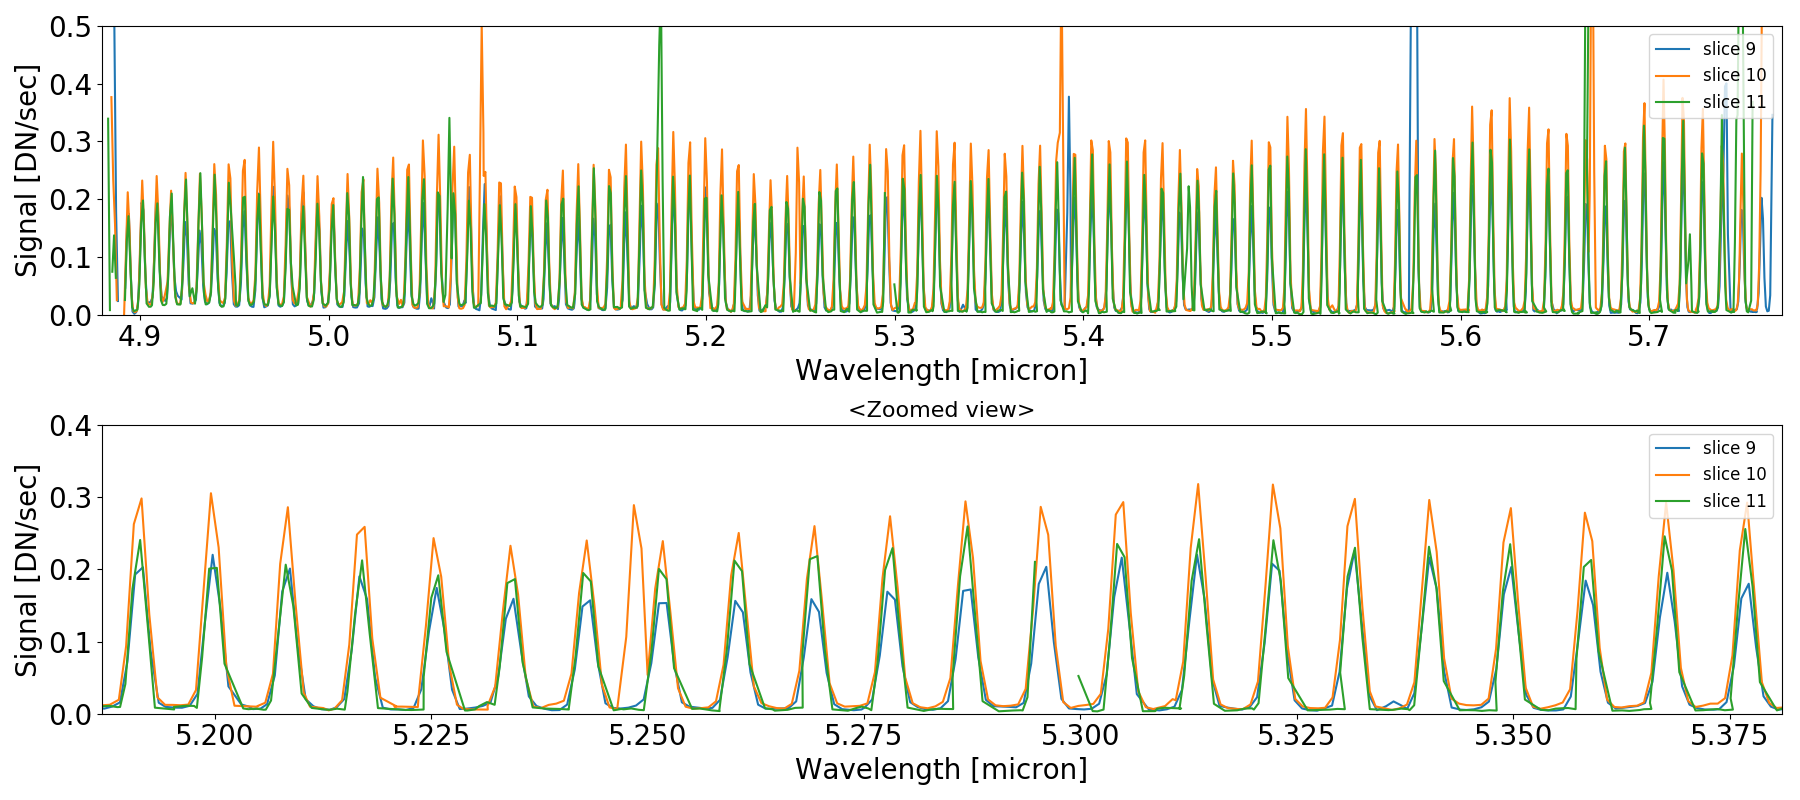

In [6]:
fig,axs = plt.subplots(2,1,figsize=(18,8))
for plot in range(2):
    axs[plot].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1],point_etal_source_oddevencorr[ypos_nearbyslice1,xpos_nearbyslice1],label='slice 9')
    axs[plot].plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice],point_etal_source_oddevencorr[ypos_sourcecenterslice,xpos_sourcecenterslice],label='slice 10')
    axs[plot].plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2],point_etal_source_oddevencorr[ypos_nearbyslice2,xpos_nearbyslice2],label='slice 11')
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Signal [DN/sec]')
    axs[plot].legend(loc='upper right',fontsize=12)
axs[0].set_xlim(4.88,5.77)
axs[0].set_ylim(0,0.5)
axs[1].set_xlim(5.187,5.381)
axs[1].set_ylim(0,0.4)
axs[1].set_title('<Zoomed view>',fontsize=16)
plt.tight_layout()

**No difference.**

### Test 2: How do the extracted point source spectra compare at different along-slice positions?

<IPython.core.display.Javascript object>


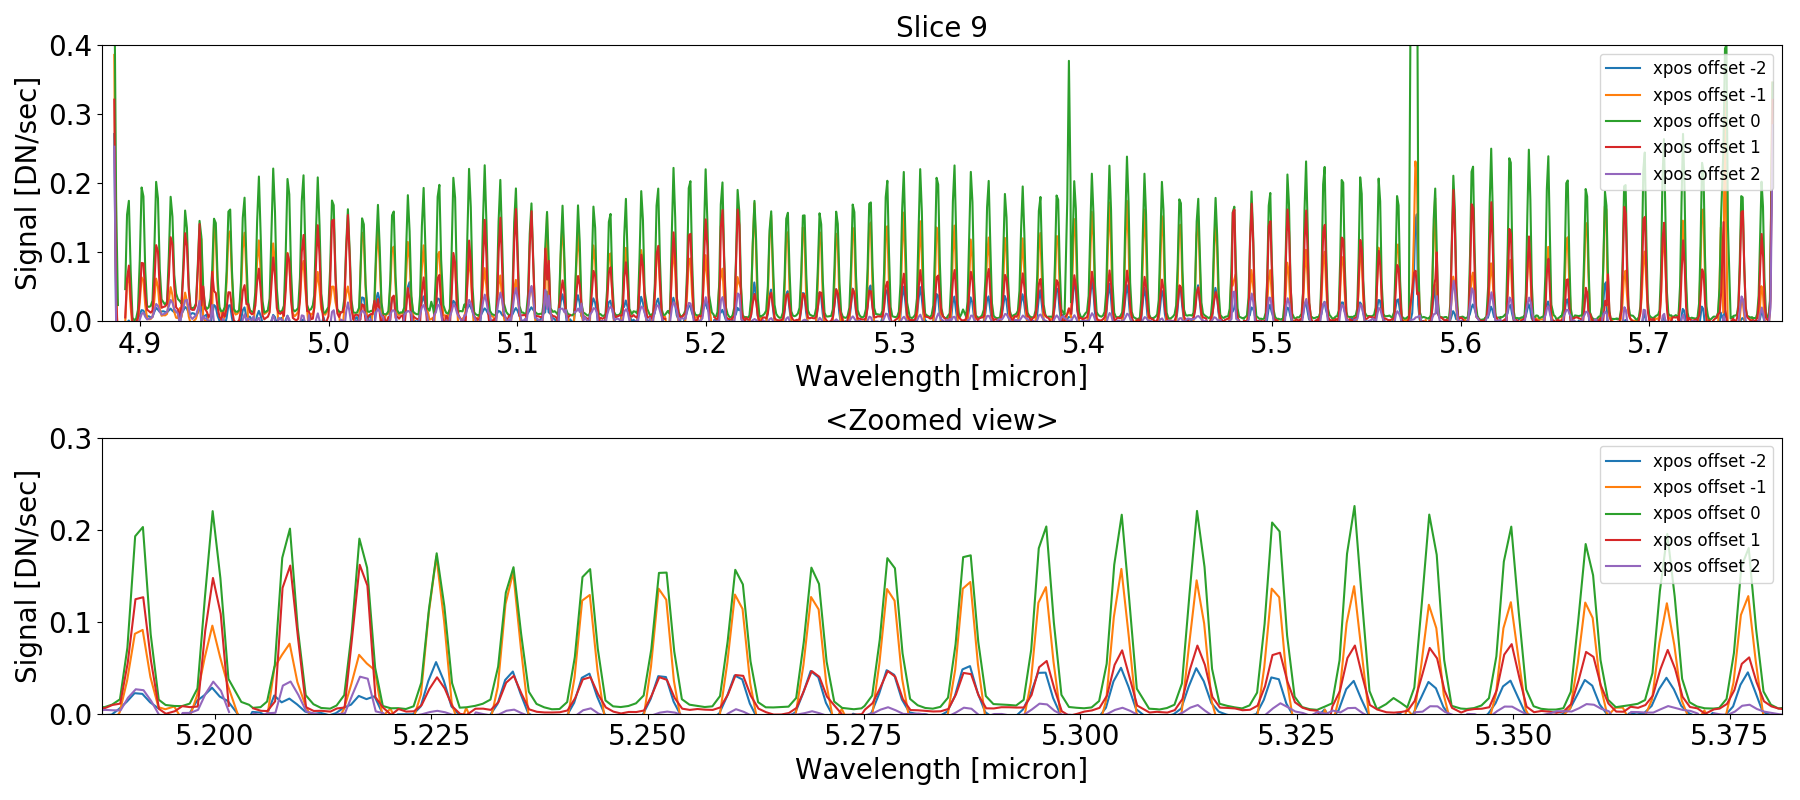

<IPython.core.display.Javascript object>


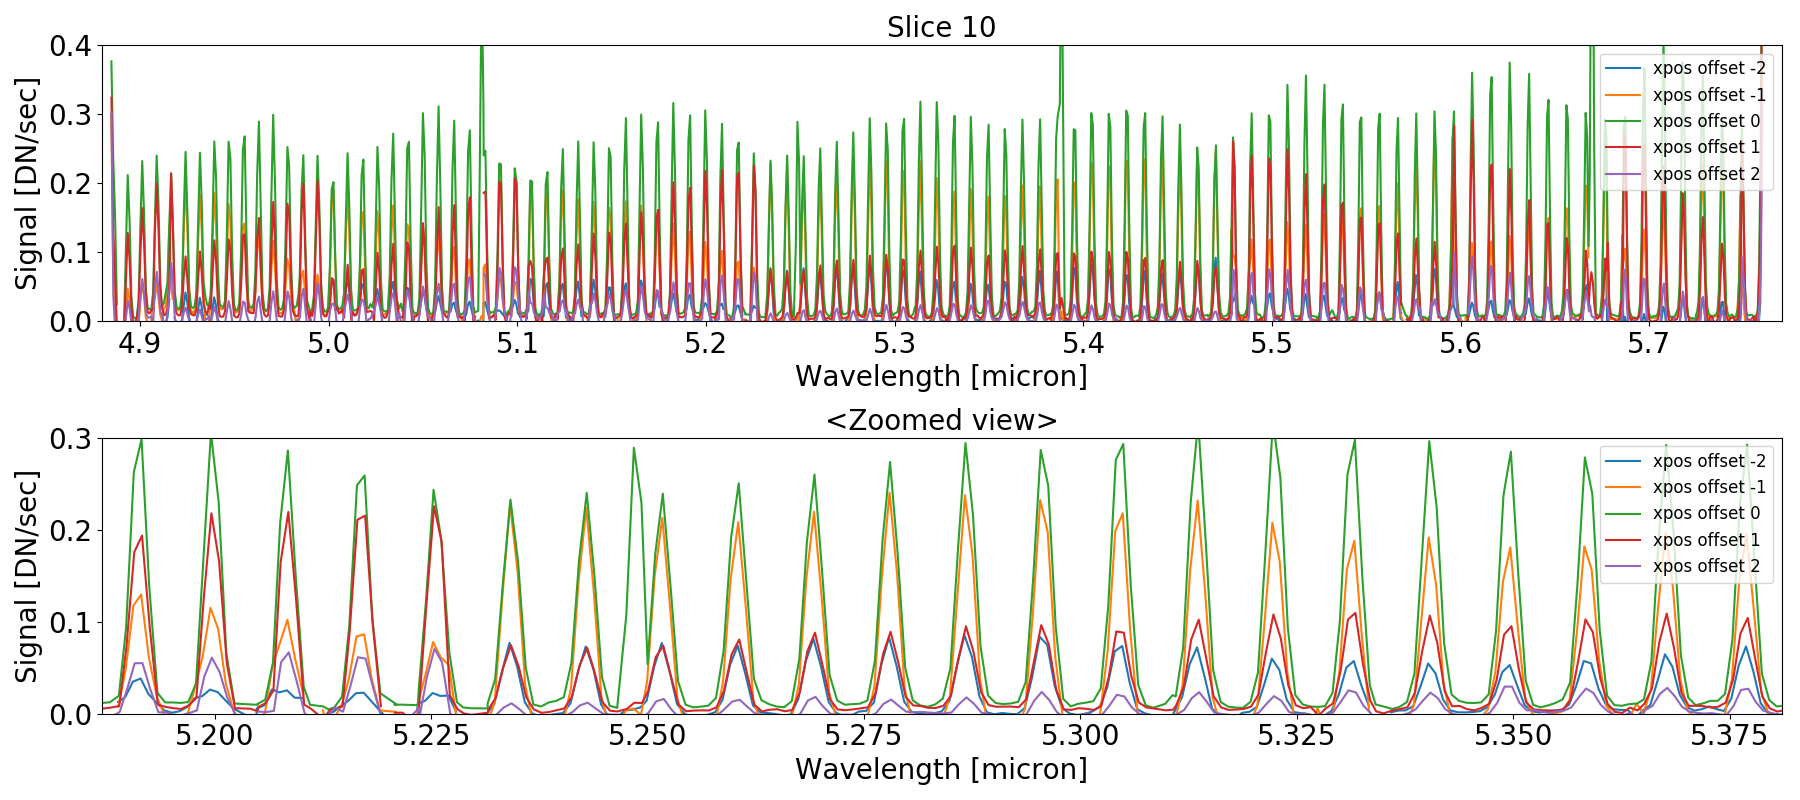

<IPython.core.display.Javascript object>


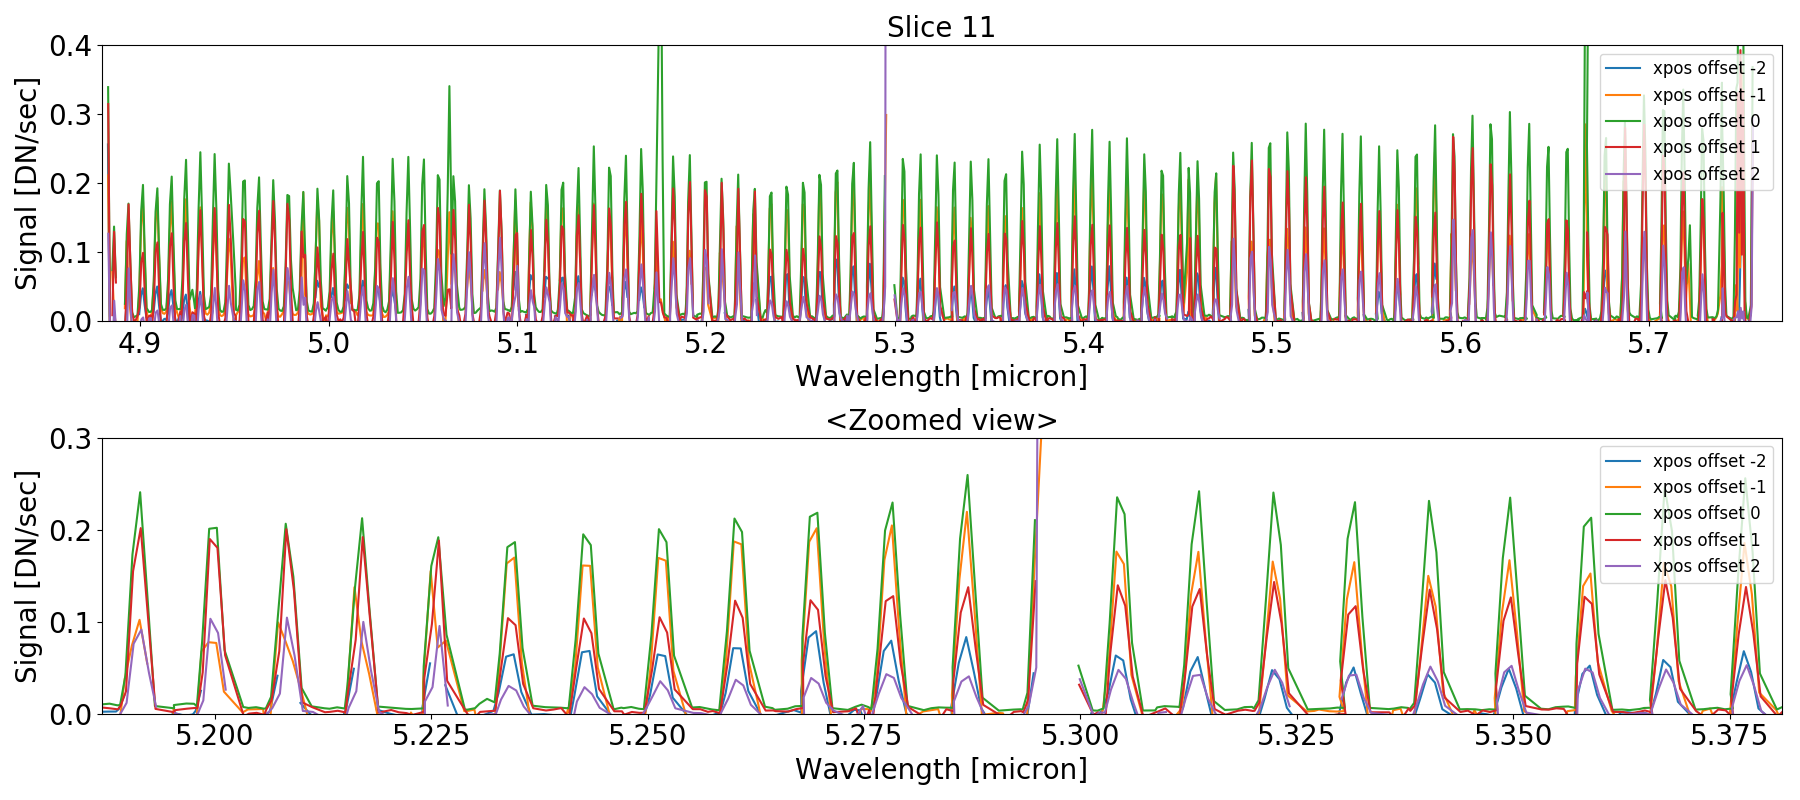

In [7]:
fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].set_title('Slice 9')
for plot in range(2):
    for xpos_offset in xpos_offsets:
        axs[plot].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset],point_etal_source_oddevencorr[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset],label='xpos offset {}'.format(xpos_offset))
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Signal [DN/sec]')
    axs[plot].legend(loc='upper right',fontsize=12)
axs[0].set_xlim(4.88,5.77)
axs[0].set_ylim(0,0.4)
axs[1].set_xlim(5.187,5.381)
axs[1].set_ylim(0,0.3)
axs[1].set_title('<Zoomed view>')
plt.tight_layout()

fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].set_title('Slice 10')
for plot in range(2):
    for xpos_offset in xpos_offsets:
        axs[plot].plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice+xpos_offset],point_etal_source_oddevencorr[ypos_sourcecenterslice,xpos_sourcecenterslice+xpos_offset],label='xpos offset {}'.format(xpos_offset))
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Signal [DN/sec]')
    axs[plot].legend(loc='upper right',fontsize=12)
axs[0].set_xlim(4.88,5.77)
axs[0].set_ylim(0,0.4)
axs[1].set_xlim(5.187,5.381)
axs[1].set_ylim(0,0.3)
axs[1].set_title('<Zoomed view>')
plt.tight_layout()

fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].set_title('Slice 11')
for plot in range(2):
    for xpos_offset in xpos_offsets:
        axs[plot].plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2+xpos_offset],point_etal_source_oddevencorr[ypos_nearbyslice2,xpos_nearbyslice2+xpos_offset],label='xpos offset {}'.format(xpos_offset))
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Signal [DN/sec]')
    axs[plot].legend(loc='upper right',fontsize=12)
axs[0].set_xlim(4.88,5.77)
axs[0].set_ylim(0,0.4)
axs[1].set_xlim(5.187,5.381)
axs[1].set_ylim(0,0.3)
axs[1].set_title('<Zoomed view>')
plt.tight_layout()

**No difference.**

### Test 3: So far the point source spectra are the same. How do they compare then to the extended source etalon spectra?
Note: we know from "notebook 1" that the extended source etalon spectra do not change with wavelength within one slice.

<IPython.core.display.Javascript object>


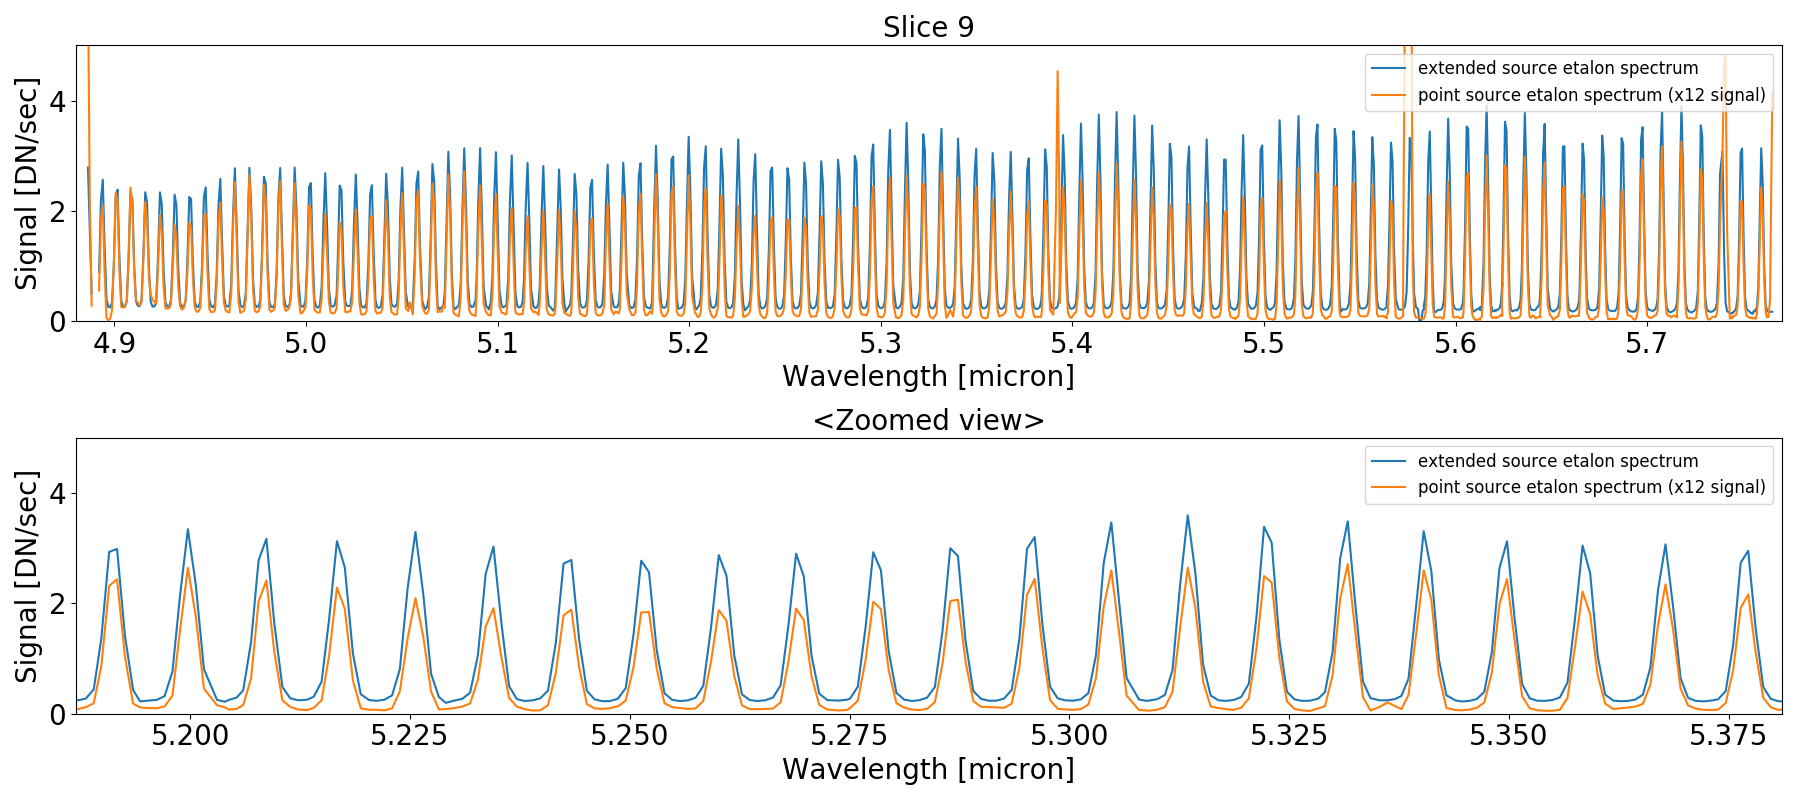

<IPython.core.display.Javascript object>


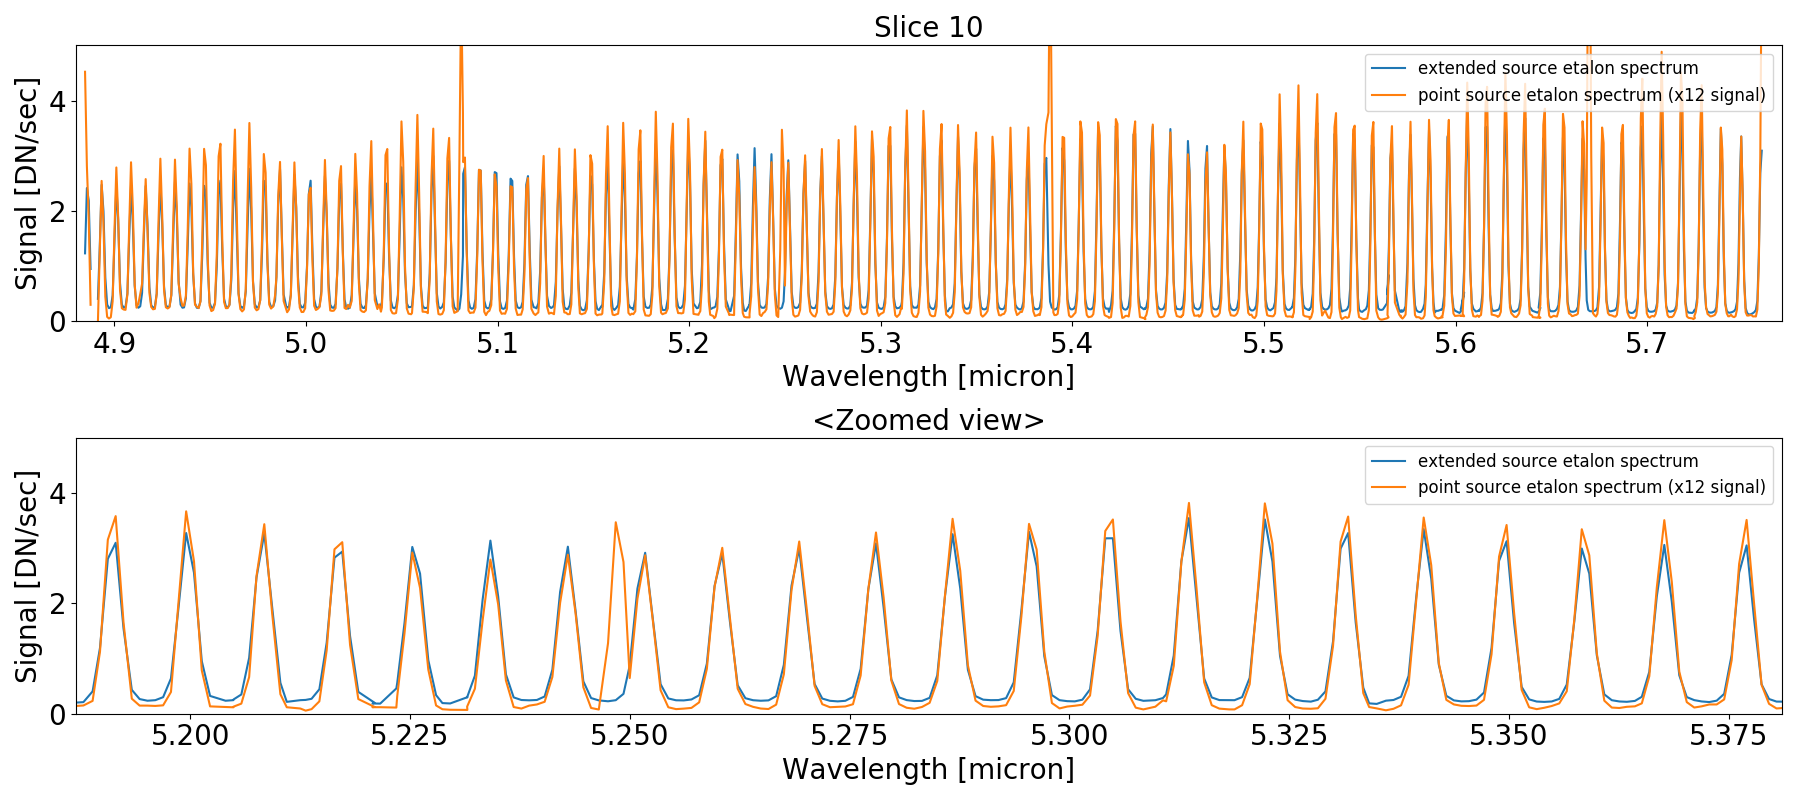

<IPython.core.display.Javascript object>


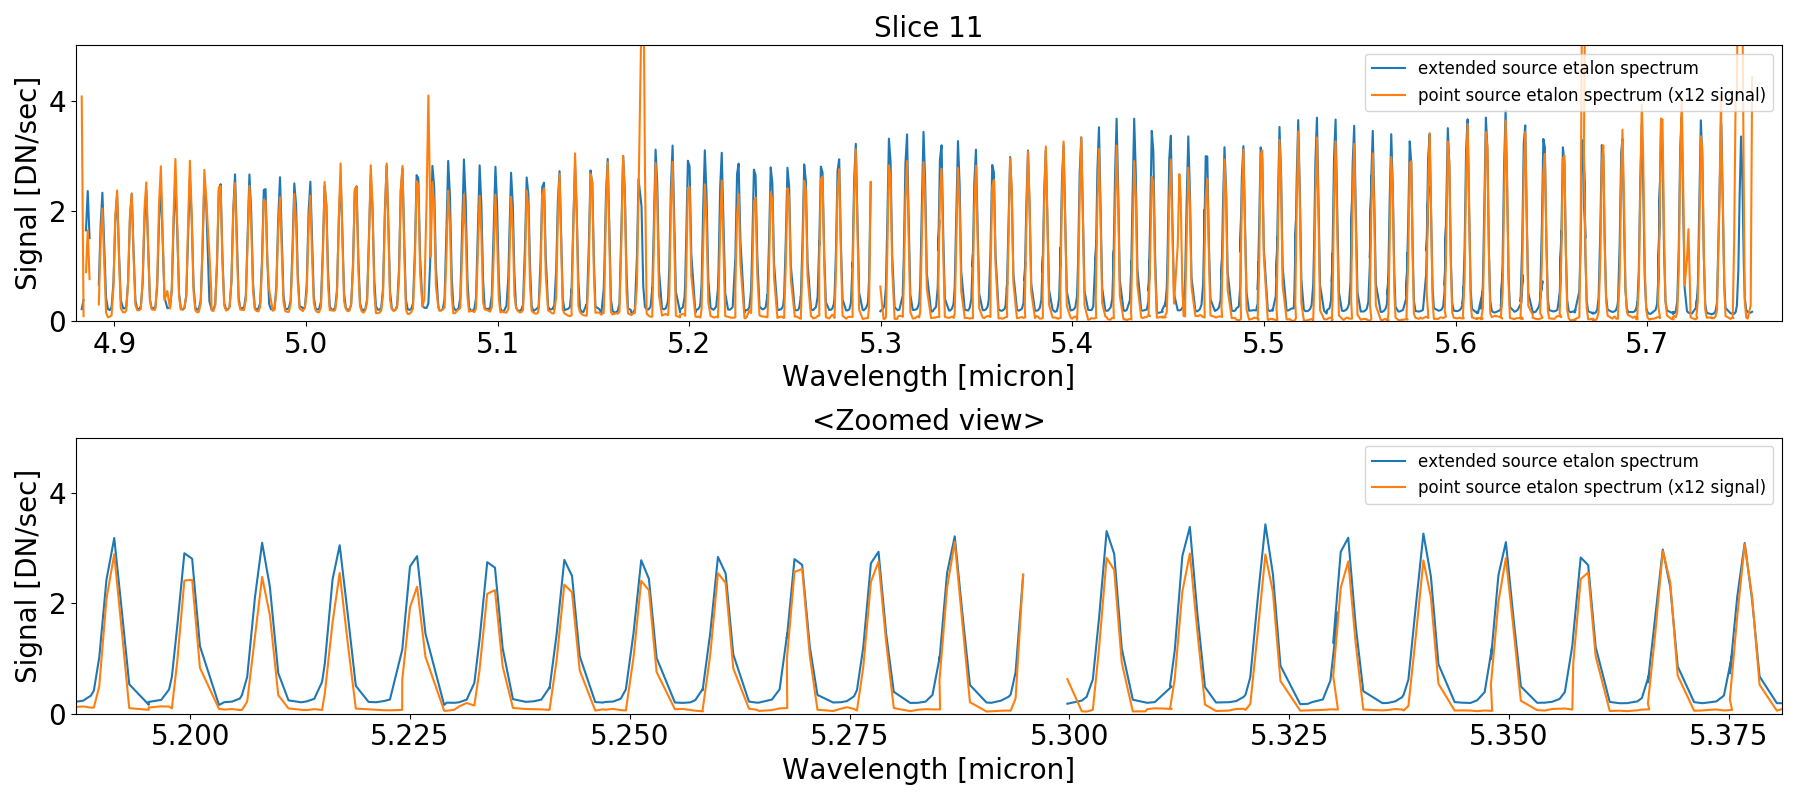

In [8]:
fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].set_title('Slice 9')
for plot in range(2):
    axs[plot].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1],ext_etal_source_oddevencorr[ypos_nearbyslice1,xpos_nearbyslice1],label='extended source etalon spectrum')
    axs[plot].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1],12*point_etal_source_oddevencorr[ypos_nearbyslice1,xpos_nearbyslice1],label='point source etalon spectrum (x12 signal)')
    axs[plot].set_ylim(0,5)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Signal [DN/sec]')
    axs[plot].legend(loc='upper right',fontsize=12)
axs[0].set_xlim(4.88,5.77)
axs[1].set_xlim(5.187,5.381)
axs[1].set_title('<Zoomed view>')
plt.tight_layout()

fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].set_title('Slice 10')
for plot in range(2):
    axs[plot].plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice],ext_etal_source_oddevencorr[ypos_sourcecenterslice,xpos_sourcecenterslice],label='extended source etalon spectrum')
    axs[plot].plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice],12*point_etal_source_oddevencorr[ypos_sourcecenterslice,xpos_sourcecenterslice],label='point source etalon spectrum (x12 signal)')
    axs[plot].set_ylim(0,5)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Signal [DN/sec]')
    axs[plot].legend(loc='upper right',fontsize=12)
axs[0].set_xlim(4.88,5.77)
axs[1].set_xlim(5.187,5.381)
axs[1].set_title('<Zoomed view>')
plt.tight_layout()

fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].set_title('Slice 11')
for plot in range(2):
    axs[plot].plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2],ext_etal_source_oddevencorr[ypos_nearbyslice2,xpos_nearbyslice2],label='extended source etalon spectrum')
    axs[plot].plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2],12*point_etal_source_oddevencorr[ypos_nearbyslice2,xpos_nearbyslice2],label='point source etalon spectrum (x12 signal)')
    axs[plot].set_ylim(0,5)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Signal [DN/sec]')
    axs[plot].legend(loc='upper right',fontsize=12)
axs[0].set_xlim(4.88,5.77)
axs[1].set_xlim(5.187,5.381)
axs[1].set_title('<Zoomed view>')
plt.tight_layout()

**No difference.**

### Test 4: We have checked that the etalon lines between the point source and extended source data match in wavelength. We must also check however the behavior of the beating (since we know that this one related to the interference introduced by the detector)

In [9]:
# Extended source etalon spectrum peaks
ext_etal_source_peaks = funcs.find_peaks(ext_etal_source_oddevencorr[ypos_nearbyslice1,xpos_nearbyslice1], thres=0.3, min_dist=6)
# Fit etalon lines
extsource_fitparams,errors,extsource_fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1],ext_etal_source_oddevencorr[ypos_nearbyslice1,xpos_nearbyslice1],ext_etal_source_peaks,fit_func='gauss1d',sigma0=0.002)
lineheights = funcs.get_amplitude(fitparams=extsource_fitparams,fitting_flag=extsource_fitting_flag)
linecenters = funcs.get_linecenter(fitparams=extsource_fitparams,fitting_flag=extsource_fitting_flag)
# Take univariate spline through the fitted peaks of the etalon lines
interpolator = InterpolatedUnivariateSpline(linecenters,lineheights,k=3,ext=3)
ext_etal_source_peakprofile = interpolator(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1])

# Point source etalon spectrum peaks
point_etal_source_peaks = funcs.find_peaks(point_etal_source_oddevencorr[ypos_nearbyslice1,xpos_nearbyslice1], thres=0.1, min_dist=6)
point_etal_source_peaks = delete(point_etal_source_peaks,where(abs(diff(point_etal_source_oddevencorr[ypos_nearbyslice1,xpos_nearbyslice1][point_etal_source_peaks] >1)) ))
# Fit etalon lines
pointsource_fitparams,errors,pointsource_fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1],point_etal_source_oddevencorr[ypos_nearbyslice1,xpos_nearbyslice1],point_etal_source_peaks,fit_func='gauss1d',sigma0=0.002)
pointsource_lineheights = funcs.get_amplitude(fitparams=pointsource_fitparams,fitting_flag=pointsource_fitting_flag)
pointsource_linecenters = funcs.get_linecenter(fitparams=pointsource_fitparams,fitting_flag=pointsource_fitting_flag)
# Take univariate spline through the fitted peaks of the etalon lines
interpolator = InterpolatedUnivariateSpline(pointsource_linecenters,pointsource_lineheights,k=3,ext=3)
point_etal_source_peakprofile = interpolator(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1])


<IPython.core.display.Javascript object>


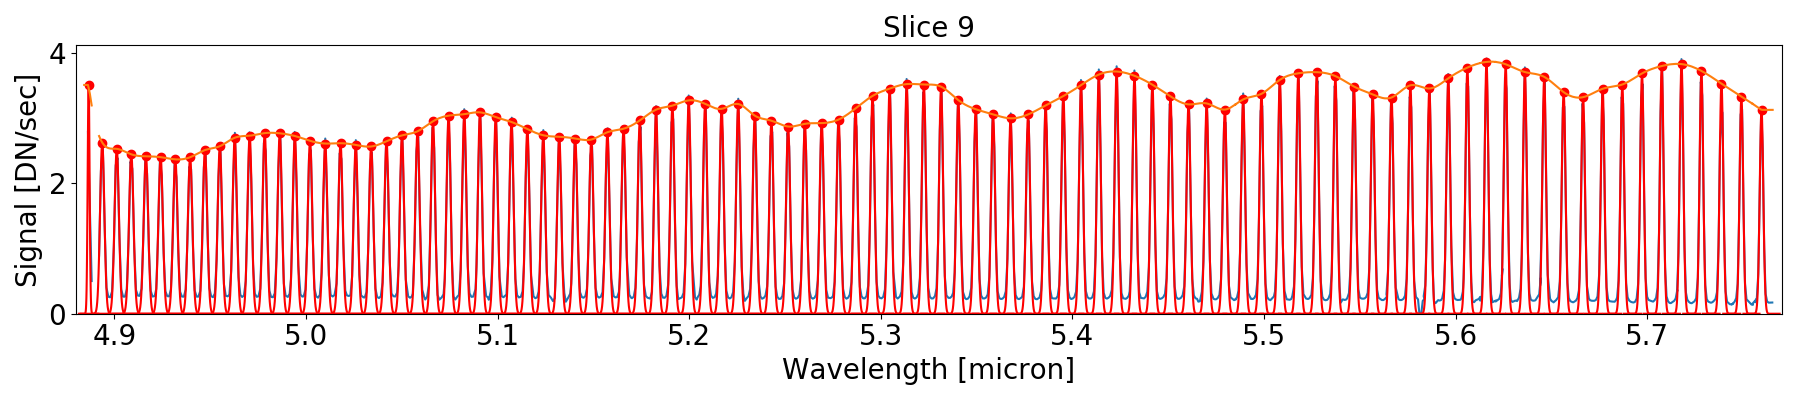

<IPython.core.display.Javascript object>


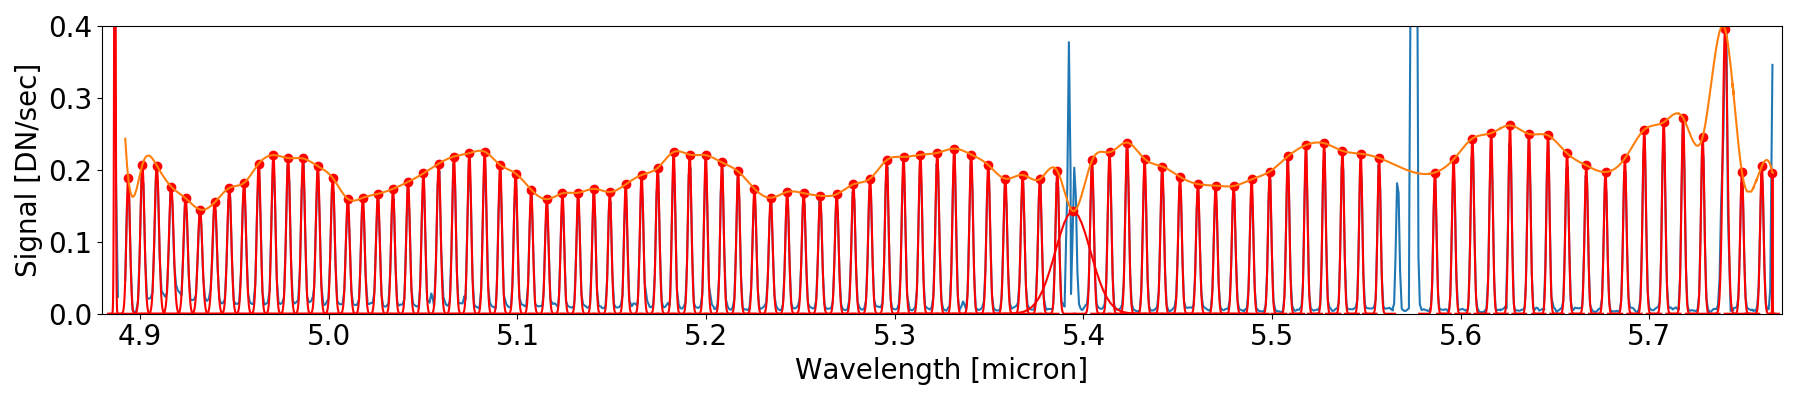

<IPython.core.display.Javascript object>


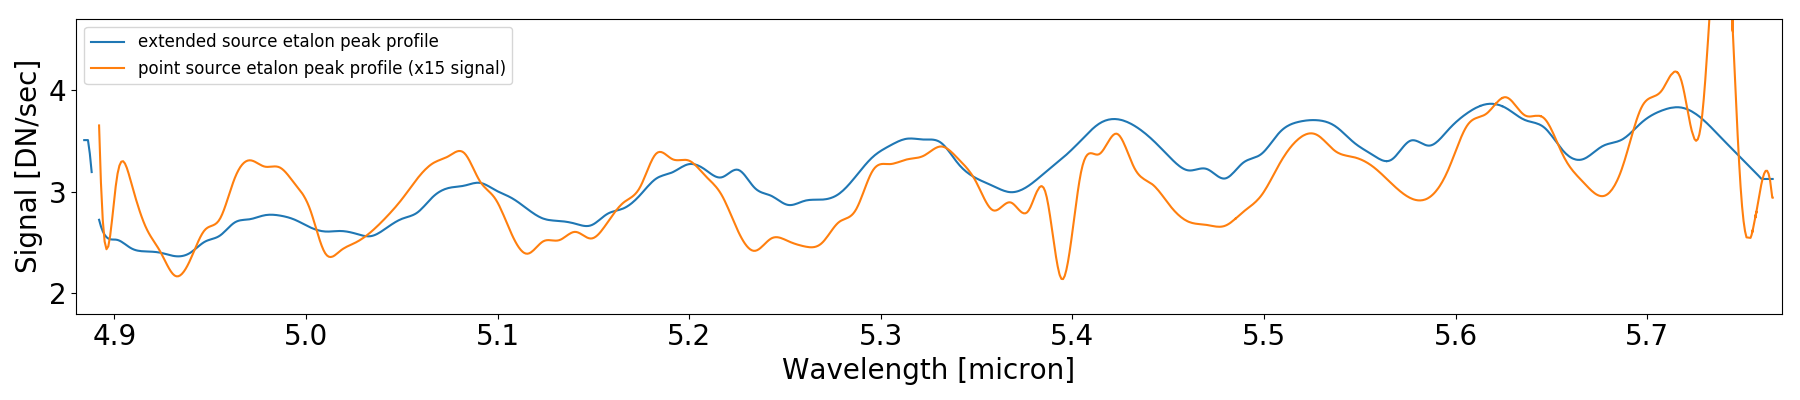

In [10]:
plt.figure(figsize=(18,4))
plt.title('Slice 9')
plt.plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1],ext_etal_source_oddevencorr[ypos_nearbyslice1,xpos_nearbyslice1])
funcs.plot_etalon_fit(fitparams=extsource_fitparams,fitting_flag=extsource_fitting_flag)
plt.plot(linecenters,lineheights,'ro')
plt.plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1],ext_etal_source_peakprofile)
plt.xlim(4.88,5.77)
plt.ylim(0)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.tight_layout()

plt.figure(figsize=(18,4))
plt.plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1],point_etal_source_oddevencorr[ypos_nearbyslice1,xpos_nearbyslice1])
funcs.plot_etalon_fit(fitparams=pointsource_fitparams,fitting_flag=pointsource_fitting_flag)
plt.plot(pointsource_linecenters,pointsource_lineheights,'ro')
plt.plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1],point_etal_source_peakprofile)
plt.xlim(4.88,5.77)
plt.ylim(0,0.4)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.tight_layout()

plt.figure(figsize=(18,4))
plt.plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1],ext_etal_source_peakprofile,label='extended source etalon peak profile')
plt.plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1],15*point_etal_source_peakprofile,label='point source etalon peak profile (x15 signal)')
plt.xlim(4.88,5.77)
plt.ylim(1.8,4.7)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='upper left',fontsize=12)
plt.tight_layout()

In [11]:
# Extended source etalon spectrum peaks
ext_etal_source_peaks = funcs.find_peaks(ext_etal_source_oddevencorr[ypos_sourcecenterslice,xpos_sourcecenterslice], thres=0.3, min_dist=6)
# Fit etalon lines
extsource_fitparams,errors,extsource_fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice],ext_etal_source_oddevencorr[ypos_sourcecenterslice,xpos_sourcecenterslice],ext_etal_source_peaks,fit_func='gauss1d',sigma0=0.002)
lineheights = funcs.get_amplitude(fitparams=extsource_fitparams,fitting_flag=extsource_fitting_flag)
linecenters = funcs.get_linecenter(fitparams=extsource_fitparams,fitting_flag=extsource_fitting_flag)
# Take univariate spline through the fitted peaks of the etalon lines
interpolator = InterpolatedUnivariateSpline(linecenters,lineheights,k=3,ext=3)
ext_etal_source_peakprofile = interpolator(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1])

# Point source etalon spectrum peaks
point_etal_source_peaks = funcs.find_peaks(point_etal_source_oddevencorr[ypos_sourcecenterslice,xpos_sourcecenterslice], thres=0.1, min_dist=6)
point_etal_source_peaks = delete(point_etal_source_peaks,where(abs(diff(point_etal_source_oddevencorr[ypos_sourcecenterslice,xpos_sourcecenterslice][point_etal_source_peaks] >1)) ))
# Fit etalon lines
pointsource_fitparams,errors,pointsource_fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice],point_etal_source_oddevencorr[ypos_sourcecenterslice,xpos_sourcecenterslice],point_etal_source_peaks,fit_func='gauss1d',sigma0=0.002)
pointsource_lineheights = funcs.get_amplitude(fitparams=pointsource_fitparams,fitting_flag=pointsource_fitting_flag)
pointsource_linecenters = funcs.get_linecenter(fitparams=pointsource_fitparams,fitting_flag=pointsource_fitting_flag)
pointsource_linesigmas  = [pointsource_fitparams[i][2] for i in range(len(pointsource_fitparams))]
# Exceptions
del pointsource_fitparams[where((pointsource_linecenters > 5.77) & (pointsource_linesigmas > 0.05))[0]]
del pointsource_fitting_flag[where((pointsource_linecenters > 5.77) & (pointsource_linesigmas > 0.05))[0]]
pointsource_lineheights = funcs.get_amplitude(fitparams=pointsource_fitparams,fitting_flag=pointsource_fitting_flag)
pointsource_linecenters = funcs.get_linecenter(fitparams=pointsource_fitparams,fitting_flag=pointsource_fitting_flag)
# Take univariate spline through the fitted peaks of the etalon lines
interpolator = InterpolatedUnivariateSpline(pointsource_linecenters,pointsource_lineheights,k=3,ext=3)
point_etal_source_peakprofile = interpolator(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice])


<IPython.core.display.Javascript object>


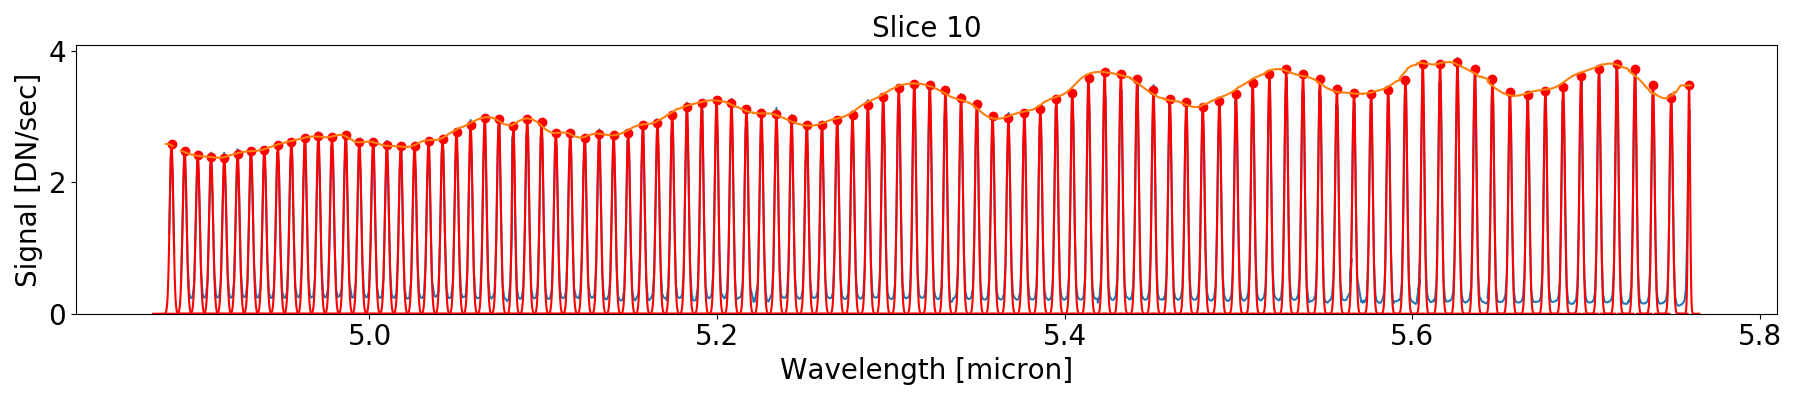

<IPython.core.display.Javascript object>


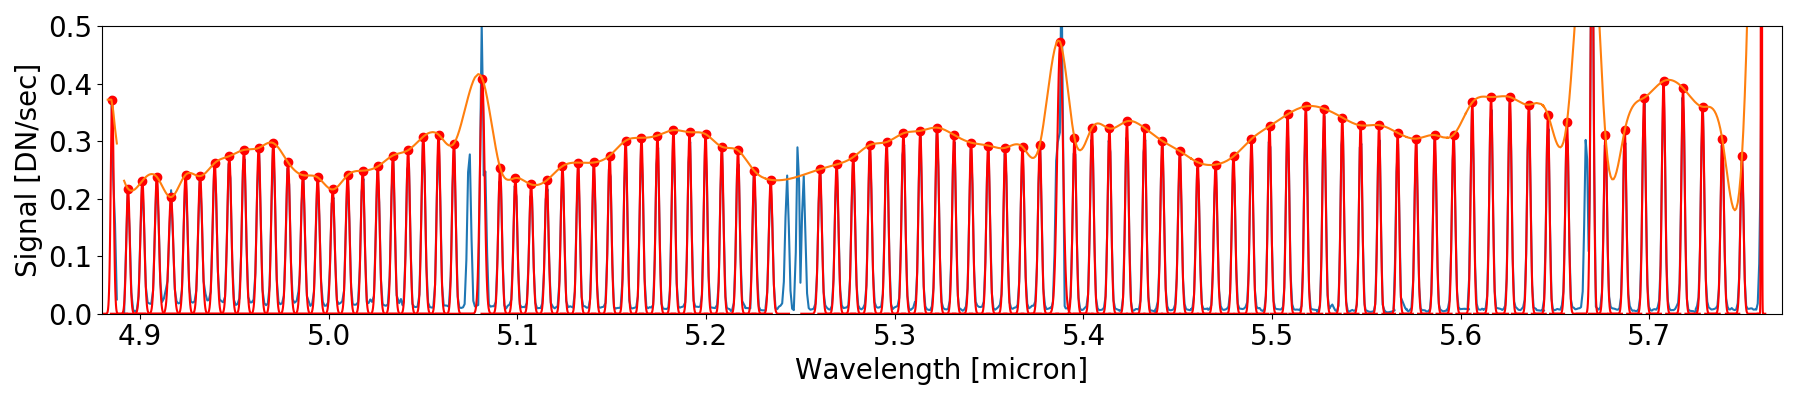

<IPython.core.display.Javascript object>


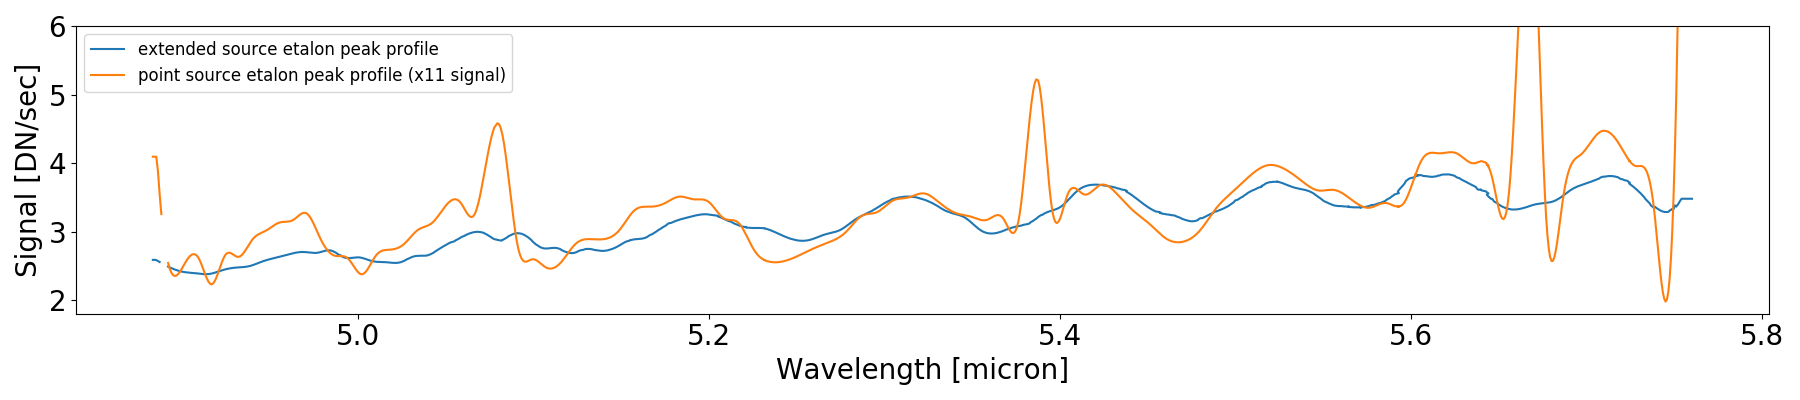

In [12]:
plt.figure(figsize=(18,4))
plt.title('Slice 10')
plt.plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice],ext_etal_source_oddevencorr[ypos_sourcecenterslice,xpos_sourcecenterslice])
funcs.plot_etalon_fit(fitparams=extsource_fitparams,fitting_flag=extsource_fitting_flag)
plt.plot(linecenters,lineheights,'ro')
plt.plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice],ext_etal_source_peakprofile)
plt.ylim(0)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.tight_layout()

plt.figure(figsize=(18,4))
plt.plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice],point_etal_source_oddevencorr[ypos_sourcecenterslice,xpos_sourcecenterslice])
funcs.plot_etalon_fit(fitparams=pointsource_fitparams,fitting_flag=pointsource_fitting_flag)
plt.plot(pointsource_linecenters,pointsource_lineheights,'ro')
plt.plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice],point_etal_source_peakprofile)
plt.xlim(4.88,5.77)
plt.ylim(0,0.5)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.tight_layout()

plt.figure(figsize=(18,4))
plt.plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice],ext_etal_source_peakprofile,label='extended source etalon peak profile')
plt.plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice],11*point_etal_source_peakprofile,label='point source etalon peak profile (x11 signal)')
plt.ylim(1.8,6)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='upper left',fontsize=12)
plt.tight_layout()

In [13]:
# Extended source etalon spectrum peaks
ext_etal_source_peaks = funcs.find_peaks(ext_etal_source_oddevencorr[ypos_nearbyslice2,xpos_nearbyslice2], thres=0.3, min_dist=6)
# Fit etalon lines
extsource_fitparams,errors,extsource_fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2],ext_etal_source_oddevencorr[ypos_nearbyslice2,xpos_nearbyslice2],ext_etal_source_peaks,fit_func='gauss1d',sigma0=0.002)
lineheights = funcs.get_amplitude(fitparams=extsource_fitparams,fitting_flag=extsource_fitting_flag)
linecenters = funcs.get_linecenter(fitparams=extsource_fitparams,fitting_flag=extsource_fitting_flag)
# Take univariate spline through the fitted peaks of the etalon lines
interpolator = InterpolatedUnivariateSpline(linecenters,lineheights,k=3,ext=3)
ext_etal_source_peakprofile = interpolator(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2])

# Point source etalon spectrum peaks
point_etal_source_peaks = funcs.find_peaks(point_etal_source_oddevencorr[ypos_nearbyslice2,xpos_nearbyslice2], thres=0.1, min_dist=6)
point_etal_source_peaks = delete(point_etal_source_peaks,where(abs(diff(point_etal_source_oddevencorr[ypos_nearbyslice2,xpos_nearbyslice2][point_etal_source_peaks] >1)) ))
# Fit etalon lines
pointsource_fitparams,errors,pointsource_fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2],point_etal_source_oddevencorr[ypos_nearbyslice2,xpos_nearbyslice2],point_etal_source_peaks,fit_func='gauss1d',sigma0=0.002)
pointsource_lineheights = funcs.get_amplitude(fitparams=pointsource_fitparams,fitting_flag=pointsource_fitting_flag)
pointsource_linecenters = funcs.get_linecenter(fitparams=pointsource_fitparams,fitting_flag=pointsource_fitting_flag)
# Take univariate spline through the fitted peaks of the etalon lines
interpolator = InterpolatedUnivariateSpline(pointsource_linecenters,pointsource_lineheights,k=3,ext=3)
point_etal_source_peakprofile = interpolator(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2])


<IPython.core.display.Javascript object>


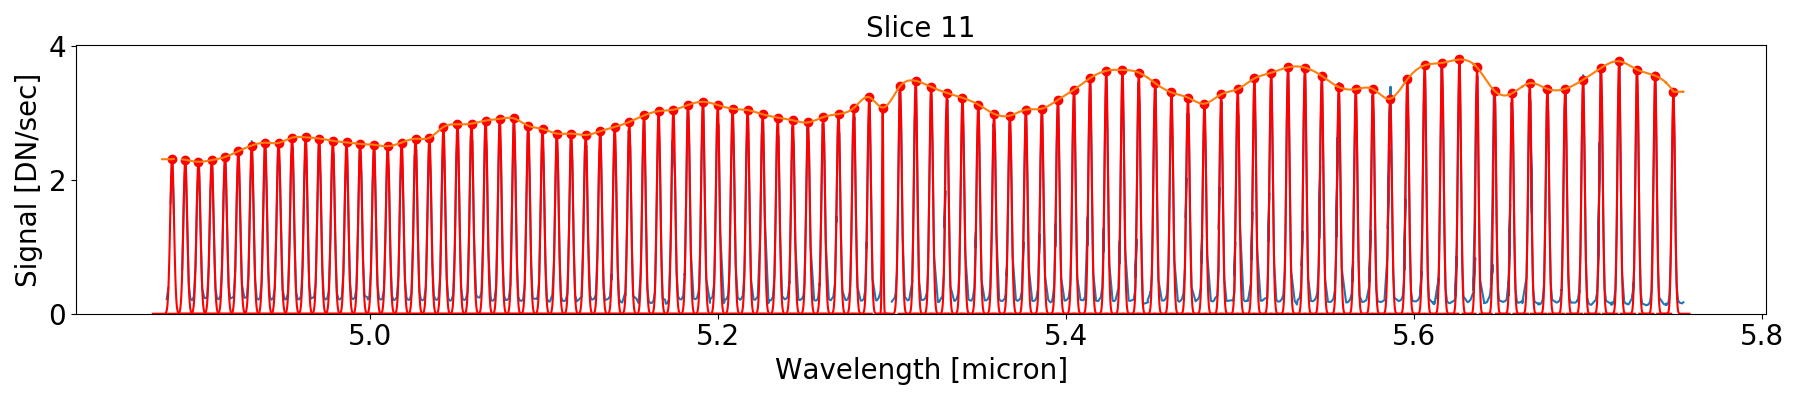

<IPython.core.display.Javascript object>


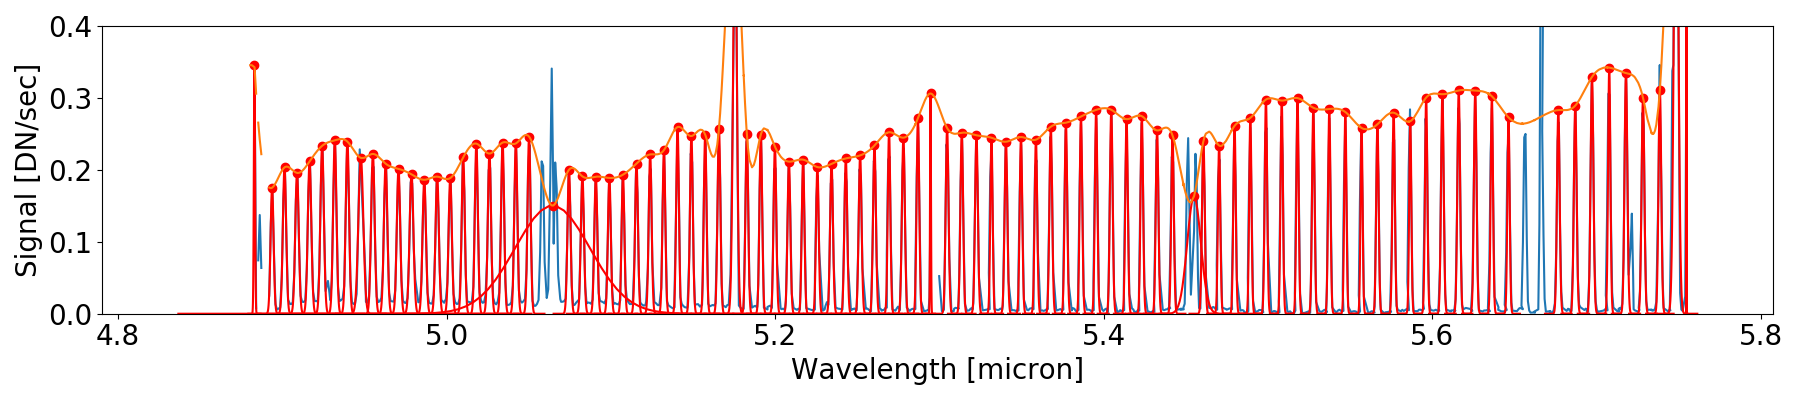

<IPython.core.display.Javascript object>


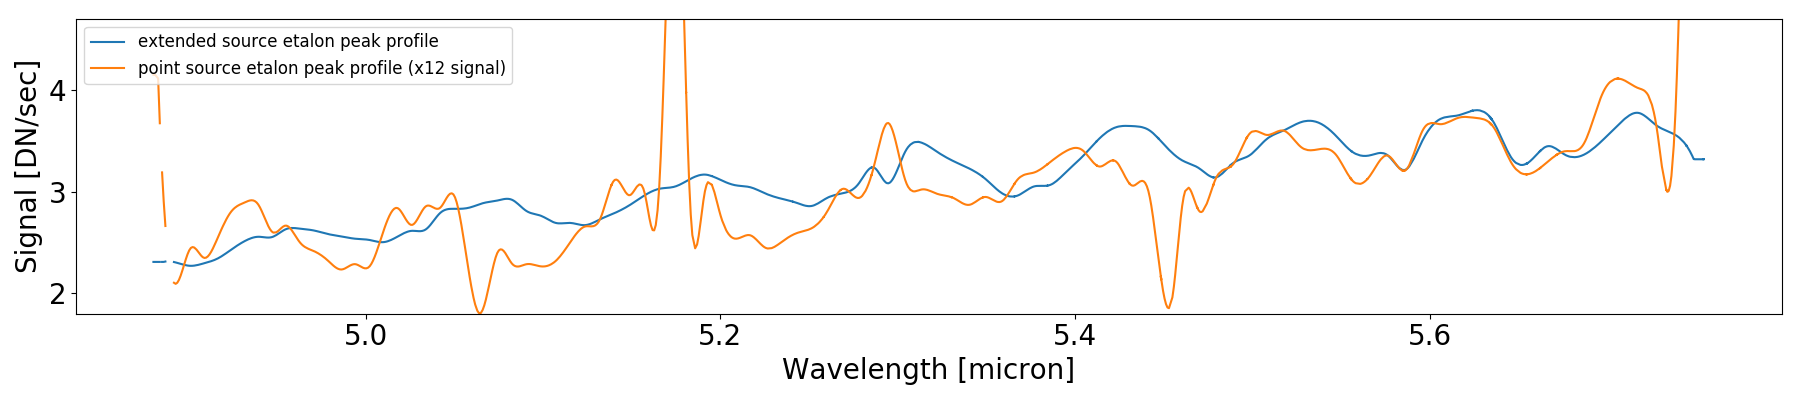

In [14]:
plt.figure(figsize=(18,4))
plt.title('Slice 11')
plt.plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2],ext_etal_source_oddevencorr[ypos_nearbyslice2,xpos_nearbyslice2])
funcs.plot_etalon_fit(fitparams=extsource_fitparams,fitting_flag=extsource_fitting_flag)
plt.plot(linecenters,lineheights,'ro')
plt.plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2],ext_etal_source_peakprofile)
plt.ylim(0)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.tight_layout()

plt.figure(figsize=(18,4))
plt.plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2],point_etal_source_oddevencorr[ypos_nearbyslice2,xpos_nearbyslice2])
funcs.plot_etalon_fit(fitparams=pointsource_fitparams,fitting_flag=pointsource_fitting_flag)
plt.plot(pointsource_linecenters,pointsource_lineheights,'ro')
plt.plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2],point_etal_source_peakprofile)
plt.ylim(0,0.4)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.tight_layout()

plt.figure(figsize=(18,4))
plt.plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2],ext_etal_source_peakprofile,label='extended source etalon peak profile')
plt.plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2],12*point_etal_source_peakprofile,label='point source etalon peak profile (x12 signal)')
plt.ylim(1.8,4.7)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='upper left',fontsize=12)
plt.tight_layout()

## Conclusions:  
* The etalon lines do not move in wavelength when compared at the position of the peak of the PSF in different slices.
* The etalon lines do not move in wavelength when compared at different positions on the PSF (checked different along-slice positions).
* The broadening of the lines is the same for point source etalon lines as for extended source etalon lines.
* Due to erratic point source signal, it is difficult to make a quantitative comparison between the beating profile of the point source etalon data and the extended source etalon data. The two seem to be in general agreement in slice 9 and 10, whilst less so in slice 11 (though one can hardly extract any more valuable information from this comparison).

## Follow-up question:  
How do the point source fringes (no etalon) change in different parts of the detector?